In [152]:
#Import Bibliotecas
import pypsa
import pandas as pd
import numpy as np


In [153]:
# =====================
# Grundparameter Standort
# =====================

roof_area = 5500                 # Gebäudefläche [m²]
number_transporter = 78          # Anzahl E-Fahrzeuge
capacitiy_battery_transporter = 40  # Batteriekapazität je Fahrzeug [kWh]
inhouse_pv = 0.35               # Max. PV-Leistung auf dem Dach [MW]





In [ ]:

# ===========
# Zeitprofile
# ===========

renewable_profile_solar = (pd.read_csv("pv_profile.csv", usecols=["electricity"]) ["electricity"].astype(float))# Lade das ninja_pv Solar-Profil für Deutschland (51.16°N, 13°E)
  # Stündliches, normiertes PV-Erzeugungsprofil

custom_load_profile_MW = (pd.read_csv("jahreslastgang_dhl (1).csv", usecols=["load_kWh"])
    ["load_kWh"].astype(float) / 1000) # Standortlastgang, von kWh/h in MW umgerechnet

#zeitprofile fleet_loead_hourly
#fleet_load_profile = (pd.read_csv("fleet_load_profile.csv", usecols=["fleet_load_MW"])["fleet_load_MW"].astype(float))  # Stündliches, normiertes Flottenladeprofil

#zeitprofile building_load_hourly
#building_load_profile = (pd.read_csv("building_load_profile.csv", usecols=["building_load_MW"])["building_load_MW"].astype(float))  # Stündliches, normiertes


In [ ]:
np.interp(temp, cop, )

KeyError: '0'

In [ ]:
# ===============================
#netzwerk erstellen with_batterie
# ===============================

with_battery = pypsa.Network()
with_battery.set_snapshots(range(8760))

#hinzufügen bus
with_battery.add("Bus", name="electricity bus", carrier="electricity")
with_battery.add("Bus", name= "h_bus", carrier="heat")
with_battery.add("Bus", name= "h_bus2", carrier="heat")

#hinzufügen generatoren
with_battery.add("Generator", name="PV", bus="electricity bus", p_nom=inhouse_pv, p_max_pu=renewable_profile_solar, marginal_cost=1)  # PV Betriebskosten: 1 €/MWh
with_battery.add("Generator", name="Grid", bus="electricity bus", p_nom_extendable=True, marginal_cost=150)  # Netzbezug: 150 €/MWh (15 Cent/kWh), fixe Leistung 10 MW

##inzufügen last
with_battery.add("Load", name="building_load", bus="electricity bus", p_set=custom_load_profile_MW*0.15)  # *0.15 da 15% des Lastprofils auf Gebäude entfallen
with_battery.add("Load", name="fleet_load", bus="electricity bus", p_set=custom_load_profile_MW*0.7)  #
with_battery.add("Load", "DHW_Load",bus="h_bus", p_set=custom_load_profile_MW * 0.05)
with_battery.add("Load", "Thermal_Load",bus="h_bus2", p_set=custom_load_profile_MW * 0.1)

#hinzufügen link
with_battery.add("Link", name="h_pump", bus0="electricity bus", bus1="h_bus", efficiency=COP, p_nom_extendable=True)
with_battery.add("Link", name="h_pump2", bus0="electricity bus", bus1="h_bus2", efficiency=COP, p_nom_extendable=True)

#hinzufügen Wärmespeicher
with_battery.add("Store", name="DHW_Storage", bus="h_bus", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=1)  # 5 MWh Speicher, 0.5% Verlust/h
with_battery.add("Store", name="Thermal_Storage", bus="h_bus2", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=1)

#hinzufügen Batteriespeicher
with_battery.add("Store", name="Battery", bus="electricity bus", carrier="electricity", e_nom_extendable=True, e_cyclic=True, capital_cost=1, overwrite=True)  # Batteriespeicher, 1% Verlust/h

In [156]:
without_battery = with_battery.copy()
without_battery.remove("Store", "Battery")

In [157]:
with_battery.optimize(solver_name='highs')
without_battery.optimize(solver_name='highs')

Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 378.57it/s]
INFO:linopy.io: Writing time: 0.29s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-5we4xsol has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 4e+00]
  Cost    [1e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 3e-01]
Presolving model
61320 rows, 65433 cols, 170550 nonzeros  0s
Dependent equations search running on 26280 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
52560 rows, 56673 cols, 153030 nonzeros  0s
Presolve reductions: rows 52560(-122646); columns 56673(-30933); nonzeros 153030(-179856) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -4.0866317871e-04 Pr: 26280(1034.96) 0s
      14592     6.3710393544e+04 Pr: 17651(170504) 5s
      29034     6.8145822845e+04 Pr: 18338(97208.8); Du: 0(7.66747e-07) 10s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 7.04e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')


      44543     7.0362767463e+04 Pr: 0(0) 13s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-5we4xsol
Model status        : Optimal
Simplex   iterations: 44543
Objective value     :  7.0362767416e+04
P-D objective error :  1.0278519083e-13
HiGHS run time      :         12.89


Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 430.00it/s]
INFO:linopy.io: Writing time: 0.24s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-ean8a274 has 148925 rows; 70085 cols; 271565 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 4e+00]
  Cost    [1e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 3e-01]
Presolving model
43800 rows, 47912 cols, 117990 nonzeros  0s
Dependent equations search running on 19438 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
36958 rows, 38878 cols, 95272 nonzeros  0s
Presolve reductions: rows 36958(-111967); columns 38878(-31207); nonzeros 95272(-176293) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     9.3991080188e+04 Pr: 19438(301.093) 0s
      20685     9.4181417450e+04 Pr: 10861(208237); Du: 0(8.72118e-08) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70085 primals, 148925 duals
Objective: 9.42e+04
Solver model: available
Solver message: Optimal



      24038     9.4210378568e+04 Pr: 0(0) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-ean8a274
Model status        : Optimal
Simplex   iterations: 24038
Objective value     :  9.4210378521e+04
P-D objective error :  1.1584581943e-15
HiGHS run time      :          5.76


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

=== Optimale Kapazitäten ===
Grid Leistung: 5.78 MW
PV Leistung: 0.35 MW
Wärmepumpe 1: 0.01 MW
Wärmepumpe 2: 0.01 MW
DHW Speicher: -0.00 MWh
Thermal Speicher: -0.00 MWh
Battery: 8.14 MWh

=== Energiemengen (MWh/Jahr) ===
PV Erzeugung: 458.1 MWh
Netzbezug: 466.0 MWh

=== Kosten-Aufschlüsselung (€/Jahr) ===
PV Kosten: 458 €
Grid Kosten: 69897 €
Wärmepumpen Betrieb: 89 €
Gesamtkosten (Betrieb): 70443 €

=== Gesamtoptimierungskosten: 70363 € ===

=== Lasten (MWh/Jahr) ===
Gebäudelast: 155.2 MWh
Fahrzeuglast: 724.5 MWh
DHW-Last: 51.7 MWh
Thermische Last: 103.5 MWh
Gesamt-Last: 1035.0 MWh


<Axes: xlabel='snapshot'>

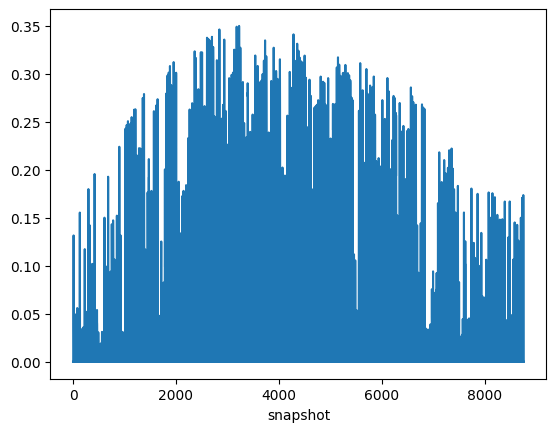

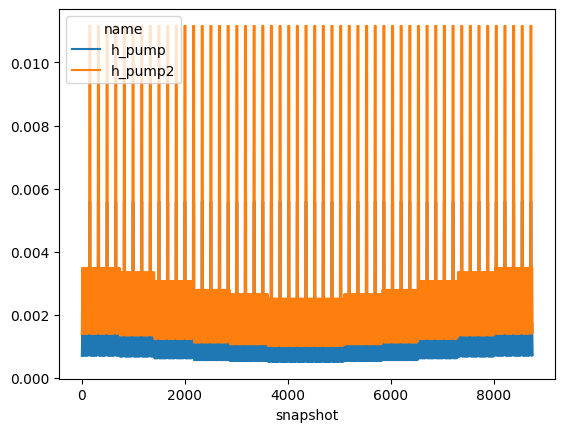

In [158]:
# ============================
# Ergebnisse abrufen & Analyse
# ============================

# 1. Optimale Kapazitäten (extendable components)
print("=== Optimale Kapazitäten ===")
print(f"Grid Leistung: {with_battery.generators.loc['Grid', 'p_nom_opt']:.2f} MW")
print(f"PV Leistung: {with_battery.generators.loc['PV', 'p_nom_opt']:.2f} MW")
print(f"Wärmepumpe 1: {with_battery.links.loc['h_pump', 'p_nom_opt']:.2f} MW")
print(f"Wärmepumpe 2: {with_battery.links.loc['h_pump2', 'p_nom_opt']:.2f} MW")
print(f"DHW Speicher: {with_battery.stores.loc['DHW_Storage', 'e_nom_opt']:.2f} MWh")
print(f"Thermal Speicher: {with_battery.stores.loc['Thermal_Storage', 'e_nom_opt']:.2f} MWh")
print(f"Battery: {with_battery.stores.loc['Battery', 'e_nom_opt']:.2f} MWh")

# 2. Energiemengen pro Komponente
print("\n=== Energiemengen (MWh/Jahr) ===")
pv_energy = with_battery.generators_t.p["PV"].sum()
grid_energy = with_battery.generators_t.p["Grid"].sum()
print(f"PV Erzeugung: {pv_energy:.1f} MWh")
print(f"Netzbezug: {grid_energy:.1f} MWh")

# 3. Kosten-Aufschlüsselung
print("\n=== Kosten-Aufschlüsselung (€/Jahr) ===")
pv_cost = pv_energy * 1  # marginal_cost=1
grid_cost = grid_energy * 150  # marginal_cost=150
h_pump_energy = with_battery.links_t.p0["h_pump"].sum() + with_battery.links_t.p0["h_pump2"].sum()
h_pump_cost = h_pump_energy * 2  # marginal_cost=2
print(f"PV Kosten: {pv_cost:.0f} €")
print(f"Grid Kosten: {grid_cost:.0f} €")
print(f"Wärmepumpen Betrieb: {h_pump_cost:.0f} €")
print(f"Gesamtkosten (Betrieb): {pv_cost + grid_cost + h_pump_cost:.0f} €")

# 4. Optimale Zielfunktion
print(f"\n=== Gesamtoptimierungskosten: {with_battery.objective:.0f} € ===")

# 5. Last-Analyse
print("\n=== Lasten (MWh/Jahr) ===")
building_load = with_battery.loads_t.p["building_load"].sum()
fleet_load = with_battery.loads_t.p["fleet_load"].sum()
dhw_load = with_battery.loads_t.p["DHW_Load"].sum()
thermal_load = with_battery.loads_t.p["Thermal_Load"].sum()
print(f"Gebäudelast: {building_load:.1f} MWh")
print(f"Fahrzeuglast: {fleet_load:.1f} MWh")
print(f"DHW-Last: {dhw_load:.1f} MWh")
print(f"Thermische Last: {thermal_load:.1f} MWh")
print(f"Gesamt-Last: {building_load + fleet_load + dhw_load + thermal_load:.1f} MWh")

with_battery.generators.p_nom_opt
 
with_battery.generators_t.p['PV'].plot()
with_battery.links_t.p0.plot()
